In [71]:
import sys
sys.path.append("..")   # add parent folder (project/) to Python path
from gplib.mf import * 
import pickle 

# Making some testing data (edit this to test at different temps)
test_temp = 550
Xtest = np.linspace(0.6, 1.4, 250).reshape(-1,1)
Xtest = np.hstack(
    (Xtest, np.ones((Xtest.shape[0], 1))*test_temp)
)

# Levels of fidelity
K = 5 

# Temperature vector 
temps = [450, 550, 650, 750, 850]

# Initializing data dict
data_dict = {} 
for level in range(K):
    data_dict[level] = {
        'X':jnp.array([[]]), 
        'Y':jnp.array([[]])
    }

# Loading the Cantera data at each temperature profile
for temp in temps:
    # Loading the data
    with open("data/FlameSpeedData%d.pkl" % temp, 'rb') as infile:
        temp_dict = pickle.load(infile)

    # Iterating through the levels of fidelity
    for level in temp_dict.keys():
        # Obtaining the number of samples
        N = temp_dict[level]['X'].shape[0]
        
        # Getting X and Y matrices
        X, Y = temp_dict[level]['X'], temp_dict[level]['Y']

        # I had two data points that were glitched out with super high LFS values, so I corrected for that here 
        Y[Y > 100] *= 1/700

        # Populating the master data dictionary with the training data at each temperature
        data_dict[level]['X'] = jnp.vstack(
            (data_dict[level]['X'].reshape(-1,2), X)
        )
        data_dict[level]['Y'] = jnp.vstack(
            (data_dict[level]['Y'].reshape(-1,1), jnp.log(Y).reshape(-1,1))
        ).ravel()

# Filtering out the high-fidelity data 
test_inds = (data_dict[4]['X'][:,1] == test_temp )
Xtrue, Ytrue = data_dict[4]['X'][test_inds,:], data_dict[4]['Y'][test_inds]
inds = (data_dict[4]['X'][:,1] <600)
data_dict[4]['X'], data_dict[4]['Y'] = data_dict[4]['X'][inds,:], data_dict[4]['Y'][inds]

# Standard Scaling each set of training and testing inputs 
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
data_dict[0]['X'] = scaler.fit_transform(data_dict[0]['X'])
for i in range(1,K):
    data_dict[i]['X'] = scaler.transform(data_dict[i]['X'])
Xtest = scaler.transform(Xtest)

# Initializing noise vars
for level in data_dict.keys():
    data_dict[level]['noise_var'] = 1e-6

# Plotting a three-dimensional scatterplot of the training and testing high-fidelity data
# fig = plt.figure(dpi=250)
# ax = fig.add_subplot(111, projection='3d')

# level = 4
# ax.scatter(scaler.inverse_transform(data_dict[level]['X'])[:,0], scaler.inverse_transform(data_dict[level]['X'])[:,1], jnp.exp(data_dict[level]['Y']).ravel(), c='blue', marker='o', label = 'Training Data')
# ax.scatter(Xtrue[:,0],Xtrue[:,1], jnp.exp(Ytrue).ravel(), marker = '*', c = 'black', label = "Unseen Testing Data")

# ax.set_xlabel('Equivalence Ratio, $\phi$')
# ax.set_ylabel('Initial Temperature, $T_0$')
# ax.set_zlabel('Flame Speed (m/s)')
# ax.legend()

# plt.title('LFS vs. Equivalence Ratio & Temperature ')

In [2]:
model = Hyperkriging(
    data_dict, RBF, Linear, max_cond = 1e5, epsilon = 1e-12
)

# Training GP-Surrogates at each level of fidelity
model.optimize(0, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-3, epochs = 250, beta = 0.9, k = 50)
model.optimize(1, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-3, epochs = 250, beta = 0.9, k = 50)
model.optimize(2, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-3, epochs = 1000, beta = 0.9, k = 50)
model.optimize(3, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-3, epochs = 2500, beta = 0.9, k = 50)

Calibrated white noise variance: 4.9785e-05
Calibrated white noise variance: 1.0000e-06
Calibrated white noise variance: 1.0000e-06
Calibrated white noise variance: 1.0000e-06
Calibrated white noise variance: 1.0000e-06
Best Objective Value: -2.2158e+03


100%|██████████| 250/250 [00:06<00:00, 37.24it/s, Loss: -2.3838e+03]


Best Objective Value: -8.0329e+02


100%|██████████| 250/250 [00:03<00:00, 64.59it/s, Loss: -1.2732e+03]


Best Objective Value: -3.8314e+02


100%|██████████| 1000/1000 [00:13<00:00, 76.84it/s, Loss: -5.3659e+02]


Best Objective Value: -3.1219e+02


100%|██████████| 2500/2500 [00:35<00:00, 69.66it/s, Loss: -3.6080e+02]


In [6]:
model.optimize(4, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-5, epochs = 5000, beta = 0.9, k = 50)

Best Objective Value: -6.1370e+01


100%|██████████| 5000/5000 [01:20<00:00, 61.83it/s, Loss: -7.4714e+01]


In [ ]:
koh = KennedyOHagan(
    data_dict, RBF, Linear, max_cond = 1e5, epsilon = 1e-12
)

koh.optimize(0, params = ['k_param', 'm_param', 'rho', 'noise_var'], lr = 1e-3, epochs = 250, beta = 0.9, k = 50)
koh.optimize(1, params = ['k_param', 'm_param', 'rho', 'noise_var'], lr = 1e-3, epochs = 250, beta = 0.9, k = 50)
koh.optimize(2, params = ['k_param', 'm_param', 'rho', 'noise_var'], lr = 1e-3, epochs = 250, beta = 0.9, k = 50)
koh.optimize(3, params = ['k_param', 'm_param', 'rho', 'noise_var'], lr = 1e-3, epochs = 1000, beta = 0.9, k = 50)


Calibrated white noise variance: 4.9785e-05
Calibrated white noise variance: 1.0000e-06
Calibrated white noise variance: 1.0000e-06
Calibrated white noise variance: 1.0000e-06
Calibrated white noise variance: 1.0000e-06
Best Objective Value: -2.2335e+03


100%|██████████| 250/250 [00:08<00:00, 31.11it/s, Loss: -2.3843e+03]


Best Objective Value: -5.8345e+02


100%|██████████| 250/250 [00:04<00:00, 50.91it/s, Loss: -1.2539e+03]


Best Objective Value: -5.1286e+02


100%|██████████| 250/250 [00:04<00:00, 57.29it/s, Loss: nan]


Best Objective Value: -2.8645e+02


100%|██████████| 1000/1000 [00:17<00:00, 58.09it/s, Loss: -3.5011e+02]


Best Objective Value: -4.2648e+01


100%|██████████| 2500/2500 [00:42<00:00, 58.59it/s, Loss: -4.8819e+01]


In [24]:
koh.optimize(4, params = ['k_param', 'm_param', 'rho', 'noise_var'], lr = 1e-3, epochs = 1000, beta = 0.0, k = 50)

Best Objective Value: -6.1638e+01


100%|██████████| 1000/1000 [00:21<00:00, 47.20it/s, Loss: -6.3630e+01]


In [8]:
nargp = NARGP(
    data_dict, NARGP_RBF, Linear, max_cond = 1e5, epsilon = 1e-16
)

# Training GP-Surrogates at each level of fidelity
nargp.optimize(0, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-3, epochs = 250, beta = 0.9, k = 50)
nargp.optimize(1, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-3, epochs = 250, beta = 0.9, k = 50)
nargp.optimize(2, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-3, epochs = 500, beta = 0.9, k = 50)
nargp.optimize(3, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-3, epochs = 1000, beta = 0.9, k = 50)

Calibrated white noise variance: 1.1000e-06
Calibrated white noise variance: 1.0000e-06
Calibrated white noise variance: 1.0000e-06
Calibrated white noise variance: 1.0000e-06
Calibrated white noise variance: 1.0000e-06
Best Objective Value: -8.3076e+02


100%|██████████| 250/250 [00:11<00:00, 21.44it/s, Loss: -2.3424e+03]


Best Objective Value: -1.0521e+03


100%|██████████| 250/250 [00:07<00:00, 34.11it/s, Loss: -1.2175e+03]


Best Objective Value: -4.8064e+02


100%|██████████| 500/500 [00:13<00:00, 37.31it/s, Loss: -5.6366e+02]


Best Objective Value: -3.5743e+02


100%|██████████| 1000/1000 [00:23<00:00, 43.39it/s, Loss: -3.7218e+02]


In [12]:
nargp.optimize(4, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-4, epochs = 2500, beta = 0.9, k = 50)

Best Objective Value: -6.3019e+01


100%|██████████| 2500/2500 [01:01<00:00, 40.86it/s, Loss: -6.5868e+01]


In [13]:
# Training Single-Fidelity Kriging model 
kr_model = GP(data_dict[4]['X'], data_dict[4]['Y'], RBF, Linear, kernel_params = jnp.ones(3), noise_var = 1e-9, epsilon = 1e-8, max_cond = 1e5, calibrate=True)
optimizer = Momentum(kr_model, neg_mll, beta = 0.9)
optimizer.kernel_latin_hypercube(15, min=-50, max = 50)
optimizer.run(1e-4, 1000, ['k_param', 'm_param', 'noise_var'])

Calibrated white noise variance: 1.0000e-09
Best Objective Value: -2.3426e+01


100%|██████████| 1000/1000 [00:16<00:00, 59.04it/s, Loss: -2.5200e+01]


In [72]:
# Making predictions with each model 
hk_mean, hk_cov = model.predict(Xtest, 4, full_cov = False)
hk_conf = 1.96 * jnp.sqrt(hk_cov)

koh_mean, koh_cov = koh.predict(Xtest, 4, full_cov = False)
koh_conf = 1.96 * jnp.sqrt(koh_cov)

nargp_mean, nargp_cov = nargp.predict(Xtest, 4, full_cov = False)
nargp_conf = 1.96 * jnp.sqrt(nargp_cov)

kr_mean, kr_cov = kr_model.predict(Xtest, full_cov = False) 
kr_conf = 1.96 * np.sqrt(kr_cov)

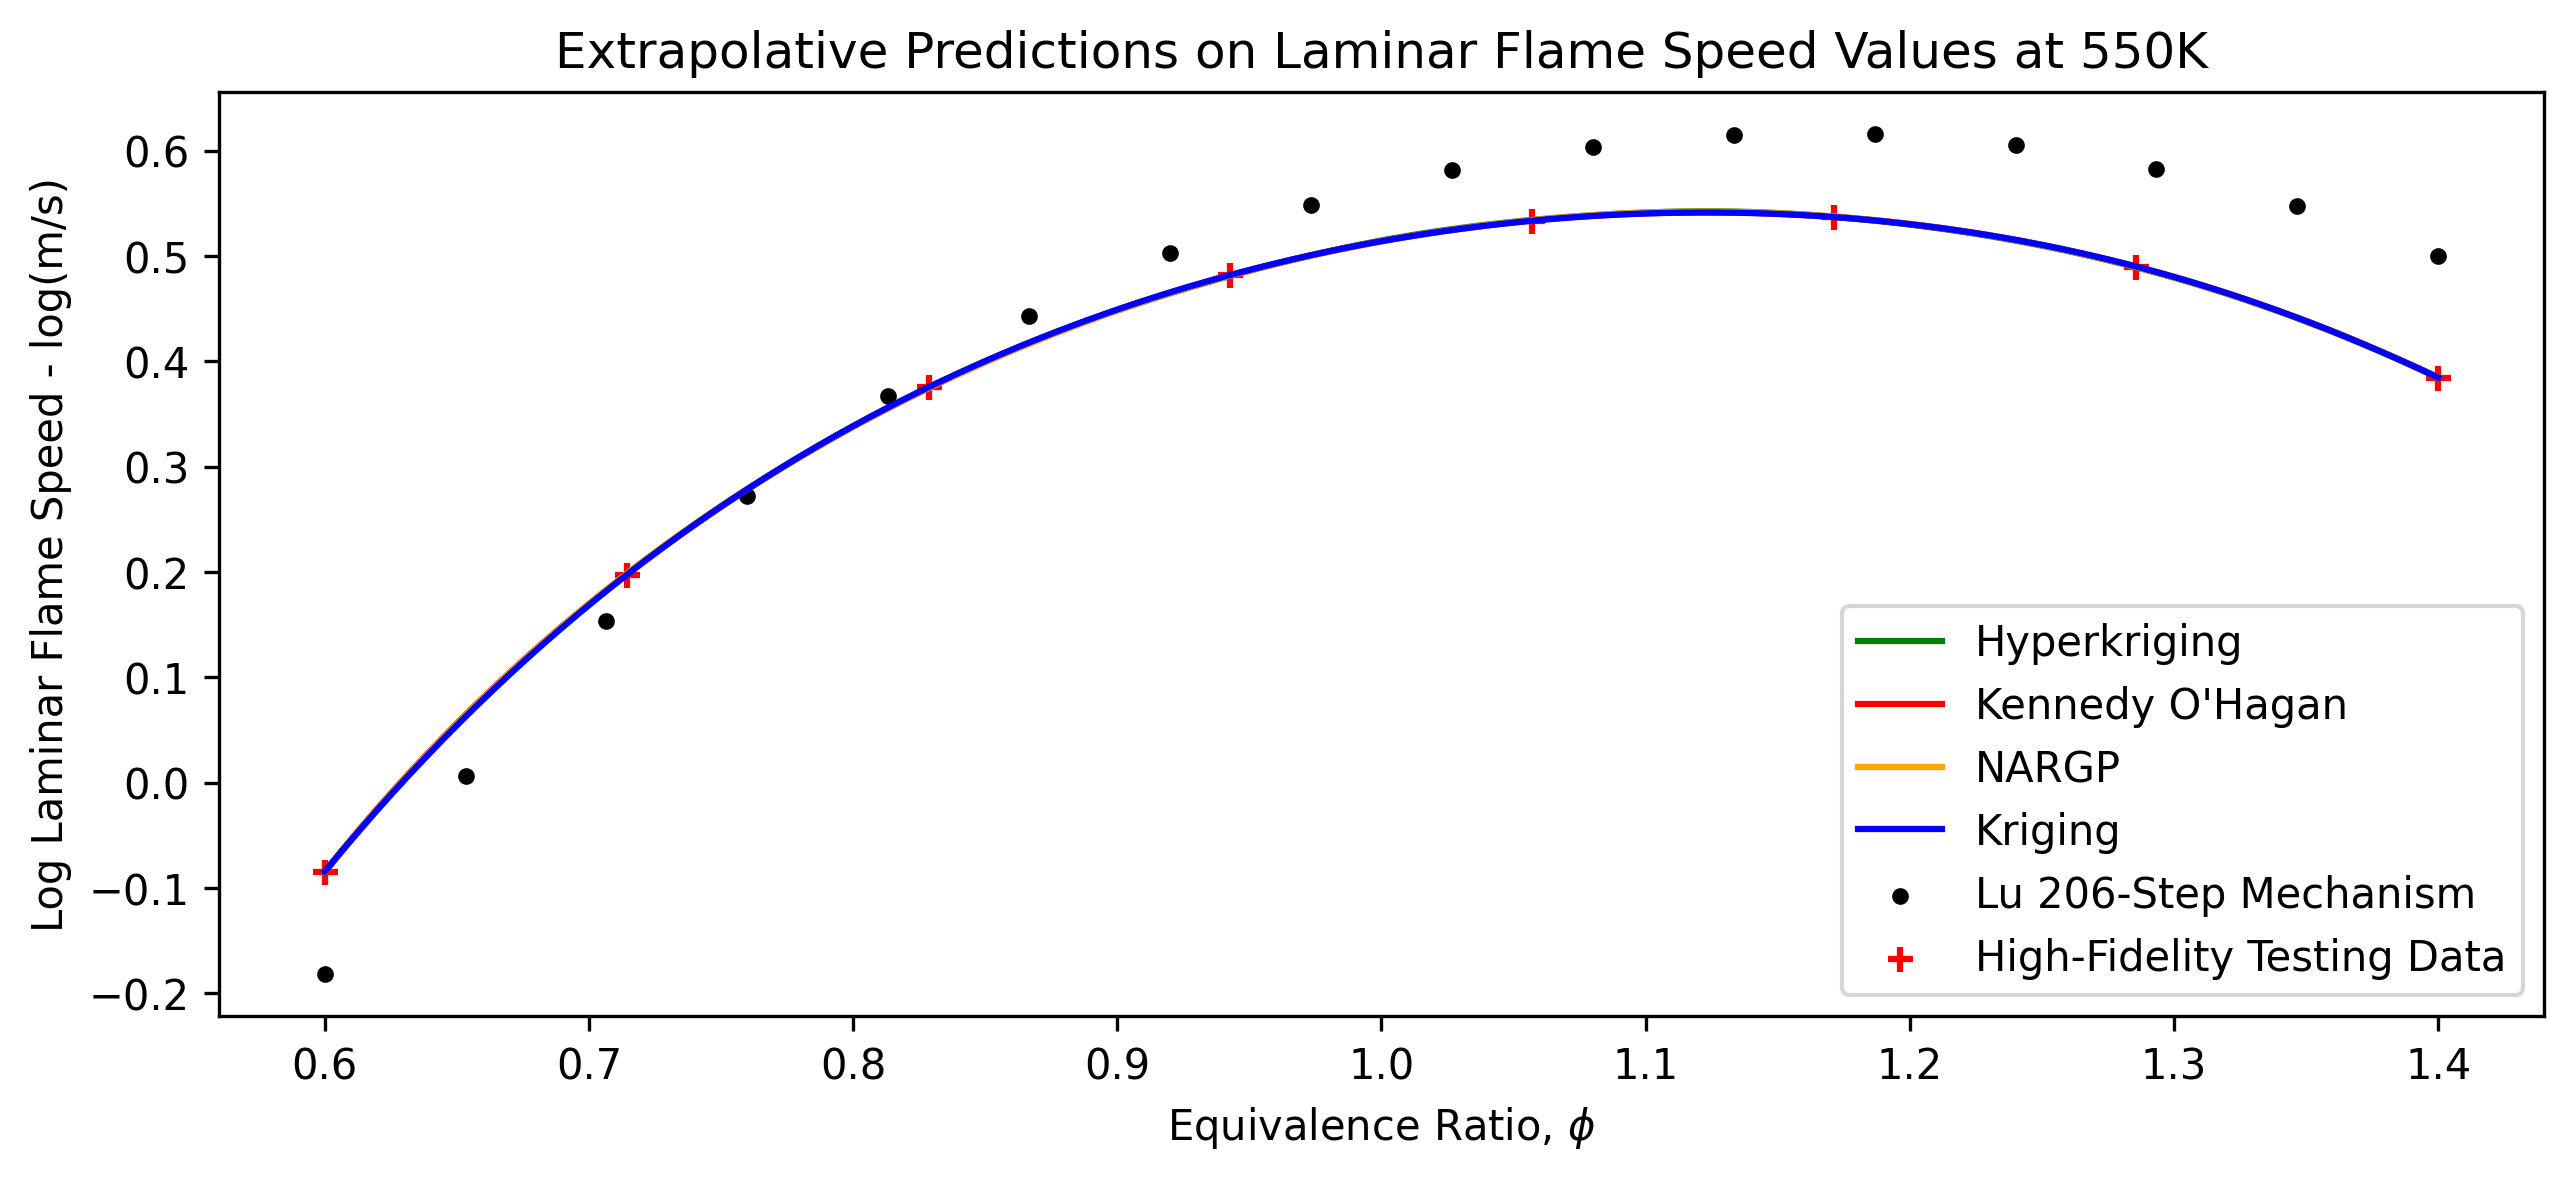

In [73]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,4),dpi = 300)

# Plotting the Hyperkriging predictions with uncertainty estimates
plt.plot(scaler.inverse_transform(Xtest)[:,0], hk_mean, color = 'green', label = 'Hyperkriging')
plt.fill_between(scaler.inverse_transform(Xtest)[:,0], hk_mean-hk_conf, hk_mean + hk_conf, color = 'green', alpha = 0.3)

# Plotting the AR1 predictions with uncertainty estimates
plt.plot(scaler.inverse_transform(Xtest)[:,0], koh_mean, color = 'red', label = 'Kennedy O\'Hagan')
plt.fill_between(scaler.inverse_transform(Xtest)[:,0], koh_mean-koh_conf, koh_mean + koh_conf, color = 'red', alpha = 0.3)

# Plotting the NARGP predictions with uncertainty estimates
plt.plot(scaler.inverse_transform(Xtest)[:,0], nargp_mean, color = 'orange', label = 'NARGP')
plt.fill_between(scaler.inverse_transform(Xtest)[:,0], nargp_mean-nargp_conf, nargp_mean + nargp_conf, color = 'orange', alpha = 0.3)

# Plotting the NARGP predictions with uncertainty estimates
plt.plot(scaler.inverse_transform(Xtest)[:,0], kr_mean, color = 'blue', label = 'Kriging')
plt.fill_between(scaler.inverse_transform(Xtest)[:,0], kr_mean-kr_conf, kr_mean + kr_conf, color = 'blue', alpha = 0.3)

# Plotting the Fidelity-3 training data for comparison 
inds = (scaler.inverse_transform(data_dict[3]['X'])[:,1] == test_temp) 
Xsim, Ysim = data_dict[3]['X'][inds,:], data_dict[3]['Y'][inds]
plt.scatter(scaler.inverse_transform(Xsim)[:,0], (Ysim), marker = '.', color = 'black', label = 'Lu 206-Step Mechanism')

# Plotting the unseen high-fidelity testing data 
plt.scatter(Xtrue[:,0], (Ytrue), marker = '+', color = 'red', label = "High-Fidelity Testing Data")

# Plot labeling 
plt.title("Extrapolative Predictions on Laminar Flame Speed Values at %dK" % (test_temp))
plt.xlabel("Equivalence Ratio, $\phi$")
plt.ylabel("Log Laminar Flame Speed - log(m/s)")
plt.legend()
# plt.savefig("figures/Results_%dK.png" % (test_temp))

In [74]:
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import Ridge
from scipy.linalg import cho_solve
from math import pi
# Fitting a degree-three polynomial through the testing points so we have a more dense error metric
features = PolynomialFeatures(degree=3)
lin_model = Ridge(alpha=1e-5)
lin_model.fit(features.fit_transform(Xtrue[:,0].reshape(-1,1)), Ytrue)
Yhat = lin_model.predict(features.transform(scaler.inverse_transform(Xtest)[:,0].reshape(-1,1))).ravel()

lin_model.fit(features.fit_transform(scaler.inverse_transform(Xsim)[:,0].reshape(-1,1)), Ysim)
Yhat_lu = lin_model.predict(features.transform(scaler.inverse_transform(Xtest)[:,0].reshape(-1,1))).ravel()

print("Method (%sK)    RMSE         R^2      log MLL" % (test_temp))
print("--------------------------------------------------")
print("Hyperkriging:    %.3e    %.4f    %.4f" % (np.sqrt(MSE(Yhat, hk_mean)), np.corrcoef(Yhat.ravel(), hk_mean.ravel())[0,1], -neg_mll(model.d[4]['model'], model.d[4]['model'].p)))
print("Kennedy O'Hagan: %.3e    %.4f    %.4f" % (np.sqrt(MSE(Yhat, koh_mean)), np.corrcoef(Yhat.ravel(), koh_mean.ravel())[0,1], -delta_neg_mll(koh.d[4]['model'], koh.d[4]['model'].p)))
print("NARGP:           %.3e    %.4f    %.4f" % (np.sqrt(MSE(Yhat, nargp_mean)), np.corrcoef(Yhat.ravel(), nargp_mean.ravel())[0,1], -neg_mll(nargp.d[4]['model'], nargp.d[4]['model'].p)))
print("Kriging:         %.3e    %.4f    %.4f" % (np.sqrt(MSE(Yhat, kr_mean)), np.corrcoef(Yhat.ravel(), kr_mean.ravel())[0,1], -neg_mll(kr_model, kr_model.p)))

Method (550K)    RMSE         R^2      log MLL
--------------------------------------------------
Hyperkriging:    6.370e-03    0.9995    74.7155
Kennedy O'Hagan: 6.580e-03    0.9995    63.6354
NARGP:           6.510e-03    0.9995    65.8680
Kriging:         6.408e-03    0.9995    25.2004
